In [23]:
import numpy as np
import pandas as pd
from uncertainties import unumpy, ufloat

import os
import glob

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from lmfit.models import Model, ConstantModel, PolynomialModel, GaussianModel, VoigtModel, LorentzianModel, PseudoVoigtModel

sns.set_context('talk')

In [24]:
# https://stackoverflow.com/questions/22348756/upright-mu-in-plot-label-retaining-original-tick-fonts
# https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib

import matplotlib
from matplotlib import rc

matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family':'sans-serif'})

params = {'text.latex.preamble':[r'\usepackage{siunitx}',
                                 r'\usepackage{amsmath}',
                                 r'\usepackage{physics}',
                                 r'\usepackage{helvet}',
                                 r'\usepackage{sansmath}',
                                 r'\sansmath',
                                 r'\sisetup{detect-all}']}
plt.rcParams.update(params)

In [113]:
# List of files to glob
POL_LIST = glob.glob('n33-spin-pol-old_freq-X_bias-2.0V-spectra-lin-lin_pol*_out.csv')
UNPOL_LIST = glob.glob('n33-unpol-X_bias-2.0V-baseline_spectra-lin-lin_pol*_out.csv')

SET_NAME = r'Checking spin-pol with n=33'
POL_NAME = r'n33-unpol-X_bias-2.0V-baseline_spectra-lin-lin_pol'
UNPOL_NAME = r'n33-spin-pol-old_freq-X_bias-2.0V-spectra-lin-lin_pol'

ATOMIC = 1505.45
ZEEMAN = 0
ORDER = 1

SATURATION_A = ufloat(44.0442405, 1.65366925)
SATURATION_B = ufloat(-0.05852900, 0.00456716)
NUM_EXPOSURES = 1000 # Number of excitation loops

# Retrieve files and do some preprocessing

### Retrieve all the data files and put in to a single DataFrame

In [114]:
# Last modified 2019/04/05
# Goes through all listed .csv files and returns data in a single DataFrame
def gather_data(file_list):
    
    # Read in .csv files in to single DataFrame
    out = pd.DataFrame()
    for file_name in file_list:
        df = pd.read_csv(file_name)
        df['Scan'] = os.path.basename(file_name)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        
        out = pd.concat([out, df], join='outer', ignore_index=True)
    
    return out

pol_data = gather_data(POL_LIST)
unpol_data = gather_data(UNPOL_LIST)

### Reduce the data by removing bad points

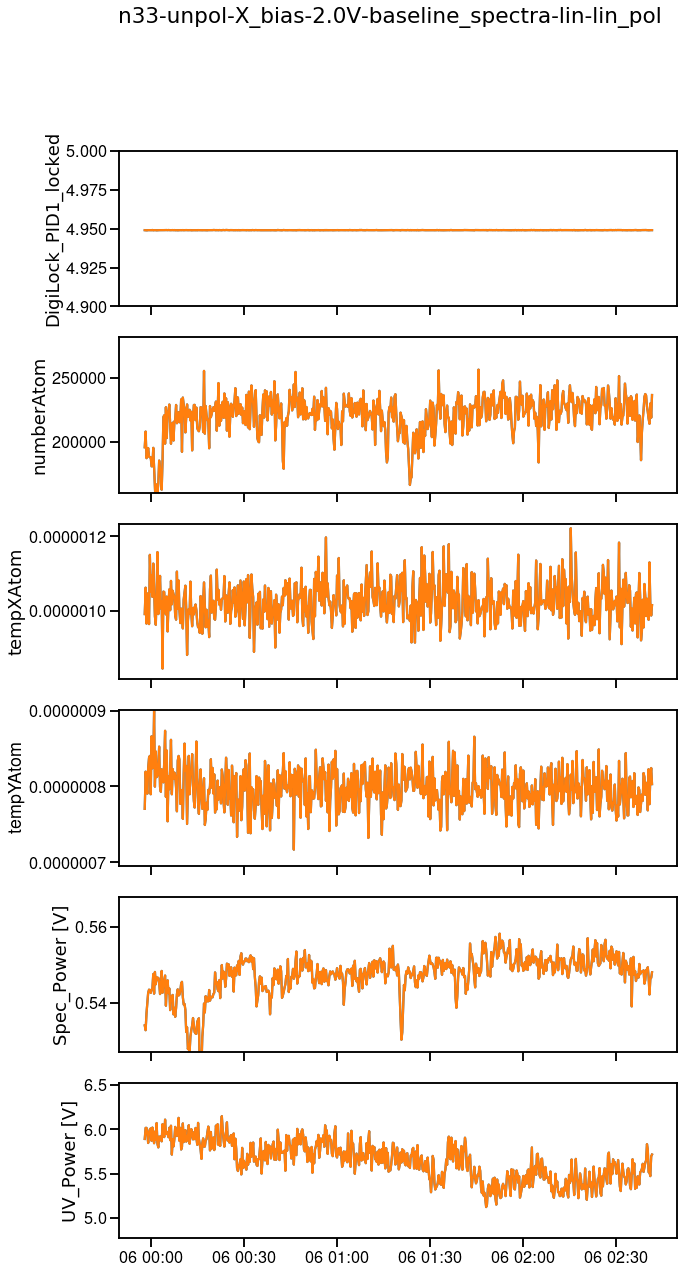

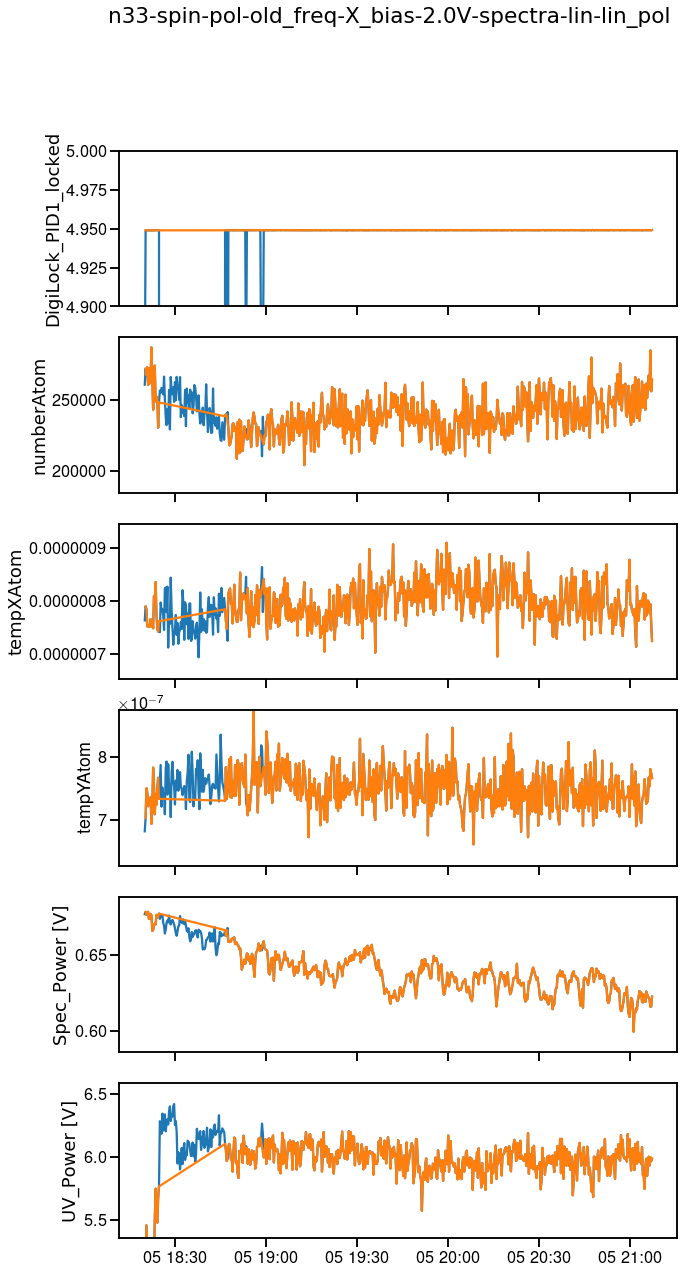

In [115]:
# First pass at removing bad data points
def reduce_data(df_data, name, show_plots):
    
    # Remove data where UV laser was not locked based on 'DigiLock_PID1_locked' column
    df_reduced = df_data[df_data['DigiLock_PID1_locked'] >= 4.9]
    
    # Remove data where atom number was above/below cutoff
    df_reduced = df_reduced[(100e3 <= df_reduced['numberAtom']) & (df_reduced['numberAtom'] <= 400e3)]
    
    # Remove data where tempYAtom was above/below cutoff
    df_reduced = df_reduced[(500E-9 <= df_reduced['tempYAtom']) & (df_reduced['tempYAtom'] <= 1.2E-6)]
    
    # Plotting original and reduced data sets
    df_orig = df_data.sort_values(by=['Timestamp'])
    df_redu = df_reduced.sort_values(by=['Timestamp'])
    
    if show_plots:
        [fig, ax]= plt.subplots(nrows=6, ncols=1, figsize=(10,20), sharex=True, sharey=False)
        fig.suptitle(name, usetex=False)

        ax[0].set_ylabel(r'DigiLock_PID1_locked', usetex=False)
        ax[0].plot(df_orig['Timestamp'], df_orig['DigiLock_PID1_locked'])
        ax[0].plot(df_redu['Timestamp'], df_redu['DigiLock_PID1_locked'])
        ax[0].set_ylim((4.9, 5))

        ax[1].set_ylabel(r'numberAtom', usetex=False)
        ax[1].plot(df_orig['Timestamp'], df_orig['numberAtom'])
        ax[1].plot(df_redu['Timestamp'], df_redu['numberAtom'])
        avg = np.mean(df_redu['numberAtom'])
        std = np.std(df_redu['numberAtom'])
        ax[1].set_ylim((avg-4*std, avg+4*std))

        ax[2].set_ylabel(r'tempXAtom', usetex=False)
        ax[2].plot(df_orig['Timestamp'], df_orig['tempXAtom'])
        ax[2].plot(df_redu['Timestamp'], df_redu['tempXAtom'])
        avg = np.mean(df_redu['tempXAtom'])
        std = np.std(df_redu['tempXAtom'])
        ax[2].set_ylim((avg-4*std, avg+4*std))

        ax[3].set_ylabel(r'tempYAtom')
        ax[3].plot(df_orig['Timestamp'], df_orig['tempYAtom'])
        ax[3].plot(df_redu['Timestamp'], df_redu['tempYAtom'])
        avg = np.mean(df_redu['tempYAtom'])
        std = np.std(df_redu['tempYAtom'])
        ax[3].set_ylim((avg-4*std, avg+4*std))

        ax[4].set_ylabel(r'Spec_Power [V]', usetex=False)
        ax[4].plot(df_orig['Timestamp'], df_orig['Spec_Power'])
        ax[4].plot(df_redu['Timestamp'], df_redu['Spec_Power'])
        avg = np.mean(df_redu['Spec_Power'])
        std = np.std(df_redu['Spec_Power'])
        ax[4].set_ylim((avg-4*std, avg+4*std))

        ax[5].set_ylabel(r'UV_Power [V]', usetex=False)
        ax[5].plot(df_orig['Timestamp'], df_orig['UV_Power'])
        ax[5].plot(df_redu['Timestamp'], df_redu['UV_Power'])
        avg = np.mean(df_redu['UV_Power'])
        std = np.std(df_redu['UV_Power'])
        ax[5].set_ylim((avg-4*std, avg+4*std))

        #plt.tight_layout()
        plt.show()
    
    # Drop unused data columns
    df_reduced.drop(columns=['AI3', 'AI4', 'AI5', 'AI6', 'AI7'], inplace=True)
    
    return df_reduced

pol_reduced = reduce_data(pol_data, POL_NAME, True)
unpol_reduced = reduce_data(unpol_data, UNPOL_NAME, True)

### Aggregrate data

In [116]:
def aggregrate_data(df_data, indVar):
    df_grouped = df_data.groupby(by=indVar, as_index=False, sort=True)
    
    #df_out = df_grouped.agg([np.mean, np.std])
    df_out = df_grouped.agg({'sfiIntegral': [np.mean, np.std],
                             'UV_Power': [np.mean, np.std],
                             'Spec_Power': [np.mean, np.std],
                             'numberAtom': [np.mean, np.std],
                             'tempXAtom':  [np.mean, np.std],
                             'tempYAtom':  [np.mean, np.std]})
    
    df_out['count'] = df_grouped.size().values
    
    return df_out

indVar = ['imagevcoAtom']

pol_out = aggregrate_data(pol_reduced, indVar)
unpol_out = aggregrate_data(unpol_reduced, indVar)

### Adjust counts due to MCP saturation

In [117]:
# Using the MCP saturation curve taken on 2019/03/27 by varying the UV power, we can account for the non-linear detection.

def mcp_saturation(df):
    df_temp = df
    observed_counts = unumpy.uarray(df_temp['sfiIntegral','mean'], df_temp['sfiIntegral','std'])
    observed_counts = observed_counts/NUM_EXPOSURES
    
    corrected_counts = -SATURATION_A*unumpy.log(1-observed_counts/SATURATION_A)
    corrected_counts = NUM_EXPOSURES*corrected_counts
    
    df_temp['sfiIntegral_linearized','mean'] = unumpy.nominal_values(corrected_counts)
    df_temp['sfiIntegral_linearized', 'std'] = unumpy.std_devs(corrected_counts)
    
    return df_temp

pol_out = mcp_saturation(pol_out)
unpol_out = mcp_saturation(unpol_out)

### Calculate detunings

In [118]:
def calc_detuning(df, atomic, zeeman, order):
    df['detuning'] = order*2*(df['imagevcoAtom'] - (atomic + order*zeeman))
    
    return df

pol_out = calc_detuning(pol_out, ATOMIC, ZEEMAN, ORDER)
unpol_out = calc_detuning(unpol_out, ATOMIC, 0, ORDER)

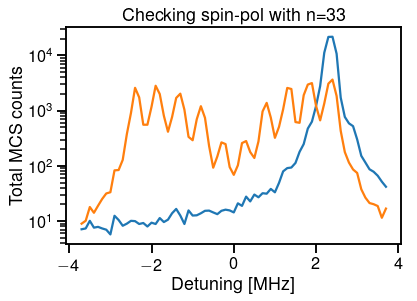

In [119]:
plt.figure()
plt.plot(pol_out['detuning'], pol_out['sfiIntegral_linearized']['mean'])
plt.plot(unpol_out['detuning'], unpol_out['sfiIntegral_linearized']['mean'])
plt.yscale('log')
plt.title(SET_NAME)
plt.xlabel('Detuning [MHz]')
plt.ylabel('Total MCS counts')
plt.show()

# Analyzing the data

In [120]:
pol_data = pol_out
unpol_data = unpol_out

### Adjust counts based on 689 nm and UV intensities

In [121]:
def adjust_for_intensities(df):
    df_temp = df
    
    raw_sfiIntegral = unumpy.uarray(df_temp['sfiIntegral_linearized', 'mean'], df_temp['sfiIntegral_linearized', 'std'])
    raw_UV_Power = unumpy.uarray(df_temp['UV_Power', 'mean'], df_temp['UV_Power', 'std'])
    raw_Spec_Power = unumpy.uarray(df_temp['Spec_Power', 'mean'], df_temp['Spec_Power', 'std'])
    
    adjusted_sfiIntegral = raw_sfiIntegral/raw_UV_Power/raw_Spec_Power
    
    df_temp['sfiIntegral_adjusted', 'mean'] = unumpy.nominal_values(adjusted_sfiIntegral)
    df_temp['sfiIntegral_adjusted', 'std'] = unumpy.std_devs(adjusted_sfiIntegral)
    
    return df_temp

# Correcting for 320 nm and 689 nm intensities point-by-point

pol_data = adjust_for_intensities(pol_data)
unpol_data = adjust_for_intensities(unpol_data)

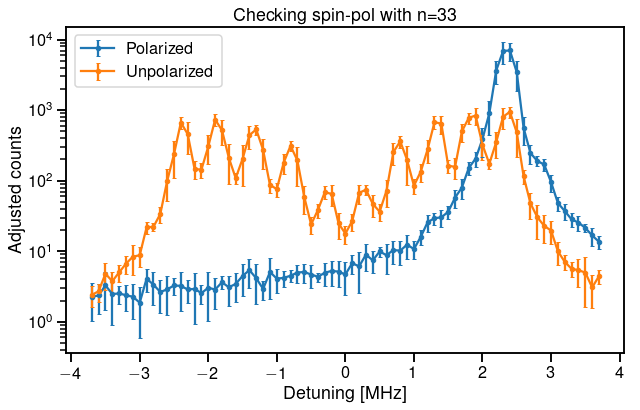

In [122]:
# Plotting results after adjusting for 320 nm and 689 nm powers

plt.figure(figsize=(10,6))
plt.errorbar(pol_data['detuning'], pol_data['sfiIntegral_adjusted', 'mean'], 
             yerr=pol_data['sfiIntegral_adjusted', 'std'],
             fmt='.-', capsize=2, label='Polarized')
plt.errorbar(unpol_data['detuning'], unpol_data['sfiIntegral_adjusted', 'mean'], 
             yerr=unpol_data['sfiIntegral_adjusted', 'std'],
             fmt='.-', capsize=2, label='Unpolarized')
plt.gca().set_yscale('log')
plt.title(SET_NAME)
plt.xlabel('Detuning [MHz]')
plt.ylabel('Adjusted counts')
plt.legend()
plt.show()

# Plots for PhD thesis

In [123]:
## Constants
#B_bias = ufloat(1.1882,0.0020) # [G] bias field extracted from Zeeman shift of 5s37s state in 84Sr
B_bias = ufloat(1.05,0.0020) # [G]
mu0 = (ufloat(1.39962449361,0.00000000042)*1E10)*(1E-4)*(1E-6) # [MHz/G] Bohr magneton
gF = 4/11 # g-factor for 5s37s, 3S1, F=11/2

### Fitting unpolarized data

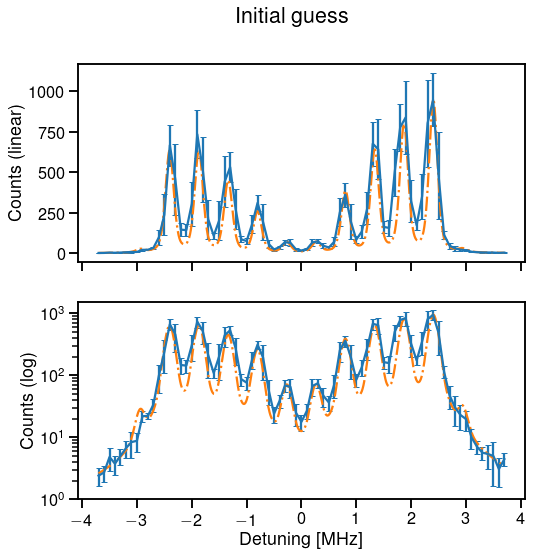

In [ ]:
data = unpol_data
plot_components = True
plot_initial_guess = True

# Choosing a range to fit over
xmin = min(data['detuning'])
xmax = max(data['detuning'])

xdata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['detuning']
ydata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'mean']
ydata_unc = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'std']

# Specify fit model
bg = PolynomialModel(degree=0, prefix='bg_')
d0 = PseudoVoigtModel(prefix='d0_')
d1 = PseudoVoigtModel(prefix='d1_')
d2 = PseudoVoigtModel(prefix='d2_')
d3 = PseudoVoigtModel(prefix='d3_')
d4 = PseudoVoigtModel(prefix='d4_')
d5 = PseudoVoigtModel(prefix='d5_')
d6 = PseudoVoigtModel(prefix='d6_')
d7 = PseudoVoigtModel(prefix='d7_')
d8 = PseudoVoigtModel(prefix='d8_')
d9 = PseudoVoigtModel(prefix='d9_')
d10 = PseudoVoigtModel(prefix='d10_')
d11 = PseudoVoigtModel(prefix='d11_')

fit_model = bg + d0 + d1 + d2 + d3 + d4 + d5 + d6 + d7 + d8 + d9 + d10 + d11
fit_params = fit_model.make_params()

#fit_params['bg_c0'].set(min(ydata), max=100, vary=True)
fit_params['bg_c0'].set(0, max=3, vary=False)
#fit_params['bg_c1'].set(2, vary=True)
#fit_params['bg_c2'].set(0, vary=True)

amplitude_scale = 1/7
sigma = 0.09
center_radius = 0.2
vary_center = True
vary_sigma = True
vary_amp = True

# m_F = -11/2 state
mF = -11/2
zs = mu0*B_bias*gF*mF
zs = zs.nominal_value
fit_params['d0_center'].set(zs, vary=vary_center, min=zs-center_radius, max=zs+center_radius)
fit_params['d0_amplitude'].set(3E1*amplitude_scale, min=0, vary=vary_amp)
fit_params['d0_sigma'].set(sigma, min=0, vary=vary_sigma)

# m_F = -9/2 state
mF = -9/2
zs = mu0*B_bias*gF*mF
zs = zs.nominal_value
fit_params['d1_center'].set(zs, vary=vary_center, min=zs-center_radius, max=zs+center_radius)
fit_params['d1_amplitude'].set(1E3*amplitude_scale, min=0, vary=vary_amp)
fit_params['d1_sigma'].set(sigma, min=0, vary=vary_sigma)

# m_F = -7/2 state
mF = -7/2
zs = mu0*B_bias*gF*mF
zs = zs.nominal_value
fit_params['d2_center'].set(zs, vary=vary_center, min=zs-center_radius, max=zs+center_radius)
fit_params['d2_amplitude'].set(1E3*amplitude_scale, min=0, vary=vary_amp)
fit_params['d2_sigma'].set(sigma, min=0, vary=vary_sigma)

# m_F = -5/2 state
mF = -5/2
zs = mu0*B_bias*gF*mF
zs = zs.nominal_value
fit_params['d3_center'].set(zs, vary=vary_center, min=zs-center_radius, max=zs+center_radius)
fit_params['d3_amplitude'].set(7E2*amplitude_scale, min=0, vary=vary_amp)
fit_params['d3_sigma'].set(sigma, min=0, vary=vary_sigma)

# m_F = -3/2 state
mF = -3/2
zs = mu0*B_bias*gF*mF
zs = zs.nominal_value
fit_params['d4_center'].set(zs, vary=vary_center, min=zs-center_radius, max=zs+center_radius)
fit_params['d4_amplitude'].set(4E2*amplitude_scale, min=0, vary=vary_amp)
fit_params['d4_sigma'].set(sigma, min=0, vary=vary_sigma)

# m_F = -1/2 state
mF = -1/2
zs = mu0*B_bias*gF*mF
zs = zs.nominal_value
fit_params['d5_center'].set(zs, vary=vary_center, min=zs-center_radius, max=zs+center_radius)
fit_params['d5_amplitude'].set(100*amplitude_scale, min=0, vary=vary_amp)
fit_params['d5_sigma'].set(sigma, min=0, vary=vary_sigma)

# m_F = 1/2 state
mF = 1/2
zs = mu0*B_bias*gF*mF
zs = zs.nominal_value
fit_params['d6_center'].set(zs, vary=vary_center, min=zs-center_radius, max=zs+center_radius)
fit_params['d6_amplitude'].set(100*amplitude_scale, min=0, vary=vary_amp)
fit_params['d6_sigma'].set(sigma, min=0, vary=vary_sigma)

# m_F = 3/2 state
mF = 3/2
zs = mu0*B_bias*gF*mF
zs = zs.nominal_value
fit_params['d7_center'].set(zs, vary=vary_center, min=zs-center_radius, max=zs+center_radius)
fit_params['d7_amplitude'].set(6E2*amplitude_scale, min=0, vary=vary_amp)
fit_params['d7_sigma'].set(sigma, min=0, vary=vary_sigma)

# m_F = 5/2 state
mF = 5/2
zs = mu0*B_bias*gF*mF
zs = zs.nominal_value
fit_params['d8_center'].set(zs, vary=vary_center, min=zs-center_radius, max=zs+center_radius)
fit_params['d8_amplitude'].set(1E3*amplitude_scale, min=0, vary=vary_amp)
fit_params['d8_sigma'].set(sigma, min=0, vary=vary_sigma)

# m_F = 7/2 state
mF = 7/2
zs = mu0*B_bias*gF*mF
zs = zs.nominal_value
fit_params['d9_center'].set(zs, vary=vary_center, min=zs-center_radius, max=zs+center_radius)
fit_params['d9_amplitude'].set(1.25E3*amplitude_scale, min=0, vary=vary_amp)
fit_params['d9_sigma'].set(sigma, min=0, vary=vary_sigma)

# m_F = 9/2 state
mF = 9/2
zs = mu0*B_bias*gF*mF
zs = zs.nominal_value
fit_params['d10_center'].set(zs, vary=vary_center, min=zs-center_radius, max=zs+center_radius)
fit_params['d10_amplitude'].set(1.5E3*amplitude_scale, min=0, vary=vary_amp)
fit_params['d10_sigma'].set(sigma, min=0, vary=vary_sigma)

# m_F = 11/2 state
mF = 11/2
zs = mu0*B_bias*gF*mF
zs = zs.nominal_value
fit_params['d11_center'].set(zs, vary=vary_center, min=zs-center_radius, max=zs+center_radius)
fit_params['d11_amplitude'].set(3E1*amplitude_scale, min=0, vary=vary_amp)
fit_params['d11_sigma'].set(sigma, min=0, vary=vary_sigma)

# Initial guess
xfit = np.linspace(min(xdata), max(xdata), num=1000, endpoint=True)
yinit = fit_model.eval(fit_params, x=xfit)

# Plotting output
if plot_initial_guess:
    [fig, axs] = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))

    axs[0].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
    axs[0].set_ylabel('Counts (linear)')

    axs[1].set_yscale('log')
    axs[1].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
    axs[1].set_ylabel('Counts (log)')
    axs[1].set_ylim(bottom=1)

    if plot_initial_guess:
        for ax in axs:
            ax.plot(xfit, yinit, '-.', label='init')
    
    fig.suptitle(r'Initial guess')
    plt.xlabel('Detuning [MHz]')
    plt.show()

# Fitting
fit_result = fit_model.fit(ydata, fit_params, x=xdata)
dely = fit_result.eval_uncertainty(x=xdata)
yfit = fit_model.eval(fit_result.params, x=xfit)

print(fit_result.fit_report())

# Plotting output
[fig, axs] = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))

axs[0].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[0].plot(xfit, yfit, label='fit')
axs[0].set_xlabel('Detuning [MHz]')
axs[0].set_ylabel('Counts (linear)')
axs[0].set_ylim(top=1000)

axs[1].set_yscale('log')
axs[1].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[1].plot(xfit, yfit, label='fit')
axs[1].set_xlabel('Detuning [MHz]')
axs[1].set_ylabel('Counts (log)')
axs[1].set_ylim(bottom=1)

if plot_components:
    # generate components
    fit_comps = fit_result.eval_components(x=xfit)
    
    for key in fit_comps.keys():
        for ax in axs:
            ax.plot(xfit, fit_comps[key], '--')

fig.suptitle(r'Fitted results')
plt.show()

unpol_fit_result = fit_result